In [10]:
import mne
import pyxdf
import numpy as np
import matplotlib.pyplot as plt

In [11]:
xdf_path = './luka_cit.xdf'
xdf_data = pyxdf.load_xdf(xdf_path)[0]
markers = xdf_data[0]
eeg = xdf_data[1]

In [12]:
# Read marker data
marker_time = markers['time_stamps']
time_offset = marker_time[0]
marker_time = marker_time - time_offset
marker_data = [x[0] for x in markers['time_series']]

In [13]:
CONST_OFFSET = 0.050

In [14]:
eeg_time = eeg['time_stamps']
eeg_time = eeg_time - time_offset - CONST_OFFSET
eeg_data = eeg['time_series'][:, :8]

In [15]:
# Create raw data
info = mne.create_info(ch_names=['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8'], ch_types=['eeg'] * 8,
                       sfreq=250)
raw = mne.io.RawArray([1e-6 * eeg_data[:, i] for i in range(8)], info)
raw.notch_filter(freqs=[50])
raw.filter(0.5, 30)
raw

<RawArray | 8 x 104476 (417.9 s), ~6.4 MiB, data loaded>

In [16]:
events = []
for i, marker in enumerate(marker_data):
    eeg_start_index = np.argmax(eeg_time >= marker_time[i]) - 1
    events.append([eeg_start_index, 0, marker])
events = np.array(events)
# events
irrelevant_events = [1, 3, 4, 5]
probe_event, target_event = [6], [2]
merged_events = mne.merge_events(events, irrelevant_events, 3)
merged_events = mne.merge_events(merged_events, probe_event, 1)
merged_events = mne.merge_events(merged_events, target_event, 2)
event_dict = dict(probe=1, target=2, irrelevant=3)
tmin, tmax = -0.2, 1
epochs = mne.Epochs(raw, merged_events, event_id=event_dict, tmin=tmin, tmax=tmax, preload=True,
                    baseline=(None, 0 if tmin < 0 else None))

In [17]:
# Assume epochs is your MNE Epochs object
probe_epochs = epochs['probe']
irrelevant_epochs = epochs['irrelevant']

n = len(probe_epochs)

n_boot = 1000
time_window = (0.3, 0.7)
picks = "Pz"

boot_diffs = []

for _ in range(n_boot):
    # Resample with replacement
    probe_resampled = probe_epochs[np.random.choice(n, n, replace=True)]
    irr_resampled = irrelevant_epochs[np.random.choice(n, n, replace=True)]

    # Average to ERP
    probe_avg = probe_resampled.average()
    irr_avg = irr_resampled.average()

    # Extract data
    probe_data = probe_avg.copy().pick(picks).data
    irr_data = irr_avg.copy().pick(picks).data

    # Time mask for P300 window
    times = probe_avg.times
    mask = (times >= time_window[0]) & (times <= time_window[1])

    # Compute P300 amplitude (max - min) in the window
    probe_p300_max = probe_data[0, mask].max()
    probe_p300_min = probe_data[0, mask].min()
    probe_p300_amp = probe_p300_max - probe_p300_min

    irr_p300_max = irr_data[0, mask].max()
    irr_p300_min = irr_data[0, mask].min()
    irr_p300_amp = irr_p300_max - irr_p300_min

    boot_diffs.append(probe_p300_amp - irr_p300_amp)

boot_diffs = np.array(boot_diffs)

# Decision criterion
perc_positive = np.mean(boot_diffs > 0) * 100
knowledgeable = perc_positive >= 90
print(f"Percent > 0: {perc_positive:.1f}%")
print("Guilty:", knowledgeable)

Percent > 0: 22.6%
Guilty: False


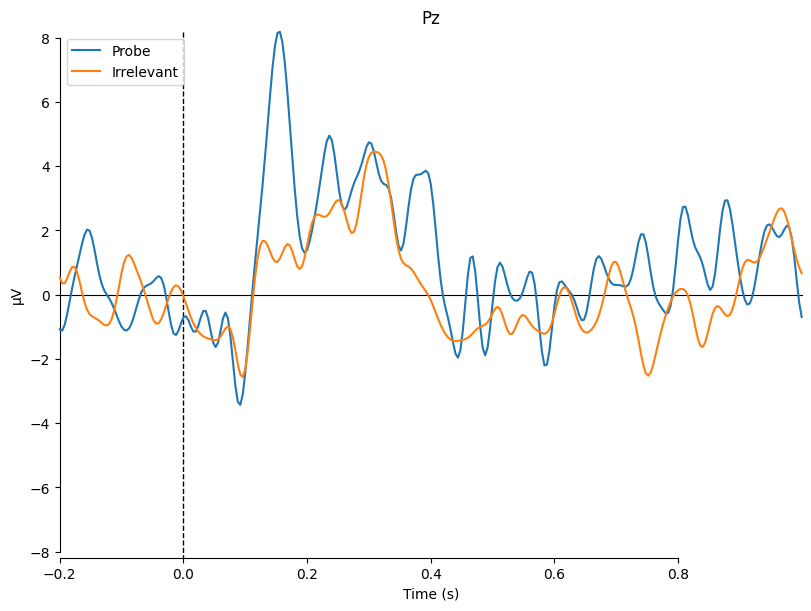

In [18]:
# Compute evokeds
probe_evoked = probe_epochs.average()
irrelevant_evoked = irrelevant_epochs.average()

# Plot together at Pz
mne.viz.plot_compare_evokeds(
    {"Probe": probe_evoked, "Irrelevant": irrelevant_evoked},
    picks="Pz",
    combine="mean",
    show=True
)

plt.show()